In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
from math import floor

In [3]:
## Preprocessing of data
# Function to load data

def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    data = pd.read_csv('data/household_power_consumption.txt',
                       sep=';', low_memory=False)

    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2                 #binary classification

    return X_train.T, X_test.T, y_train, y_test, no_class

In [4]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (6, 1536960)
Y size (1536960,)


Let
\begin{align}
    E=\min_{w_3, W_2,W_1} \frac{1}{N}\sum_i || w_3 s(W_2 s(W_1 x_i)-y_i)||^2   
\end{align}

## Layer 3
Define 
\begin{align}
a_3(x)& :=w_3 s(W_2 s(W_1 x))\\
a_2(x)& :=s(W_2 s(W_1 x)),\\
a_1(x)& :=s(W_1 x).
\end{align}

Then
\begin{align}
\frac{\partial E}{\partial w_3} &= \frac{2}{N}(a_3-t)\frac{\partial a_3}{\partial w_3} \\
&=\frac{2}{N}(x_3-t)\frac{\partial w_3a_2}{\partial w_3}\\
&=\frac{2}{N}(x_3-t)a_2^T\\
\end{align}

So defining 
$$\delta_3 := \frac{2}{N}(a_3-t),$$
then
$$\frac{\partial E}{\partial w_3} =\delta_3\,a_2^T.$$

## Layer 2

\begin{align*}
\frac{\partial E}{\partial W_2} &= \frac{2}{N}(a_3-t)\frac{\partial a_3}{\partial W_2} \\
&=\frac{2}{N}(a_3-t)\frac{\partial (W_3 a_2)}{\partial W_2}\\
&=\delta_3\frac{\partial (W_3 a_2)}{\partial W_2}\\
&=W_3^T\delta_3\frac{\partial a_2}{\partial W_2}\\
&=[W_3^T\delta_3 \circ s'(W_2 a_1)]\frac{\partial W_2 a_1}{\partial W_2}\\
\end{align*}

So defining $$\delta_2 :=W_3^T\delta_3 \circ s'(W_2 a_1),$$
we have

$$\frac{\partial E}{\partial W_2}=\delta_2 a_1^T$$

## Layer 1

Define 
$$\delta_1 :=W_2^T\delta_2 \circ s'(W_1x),$$
similar to layer_2:
\begin{align*}
\frac{\partial E}{\partial W_1} &=\delta_1x^T
\end{align*}

In [8]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    #X is q x n
    # w_1 is p x q
    # w_2 is p x p
    # w_3 is 1 x p
    layer_0=X # q x n
    layer_1=sigmoid(np.matmul(w_1 , X)) # p x n 
    layer_2=sigmoid(np.matmul(w_2 , layer_1)) # p x n 
    layer_3=np.matmul(w_3 , layer_2) # p x n
    return layer_0, layer_1, layer_2, layer_3


# Fill in backpropagation    
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    N = y.shape[0]    
        
    delta3=2/N*(layer_3 - y)
    delta2=np.multiply(np.matmul(w_3.T,delta3),sigmoid(np.matmul(w_2,layer_1),derivative=True))
    delta1=np.multiply(np.matmul(w_2.T,delta2),sigmoid(np.matmul(w_1,layer_0),derivative=True))
    
    layer_3_delta=np.matmul(delta3,layer_2.T)
    layer_2_delta=np.matmul(delta2,layer_1.T)
    layer_1_delta=np.matmul(delta1,layer_0.T)

    return layer_1_delta, layer_2_delta, layer_3_delta


# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)

    return np.linalg.norm(a4[:,0] - y,2) ** 2 / N

# Funtion to get mini batch sgd
def miniBatch(x,y,batchSize):
    D,N = x.shape
    X_mini = np.zeros((D,batchSize))
    Y_mini = np.zeros((batchSize,))
    indexArray = random.sample(range(N), batchSize)
    for i in range(batchSize):
        X_mini[:,i] = x[:,indexArray[i]]
        Y_mini[i,] = y[indexArray[i],]
    return X_mini,Y_mini

# Define SGD
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, iterations):
    cost_l=[]
    ti= np.zeros((iterations,1))
    start = time.time()
    for i in range(iterations):

        X_mini,Y_mini = miniBatch(X,y,batch_size)
        L0,L1,L2,L3 = feed_forward_propagation(X_mini,Y_mini,w_1,w_2,w_3,lmbda)
        D1,D2,D3 = back_propagation(Y_mini,w_1,w_2,w_3,L0,L1,L2,L3)

        #cost1 = cost(X_mini, Y_mini, w_1, w_2, w_3, lmbda)
        
        a = w_1-(learning_rate*D1).reshape(w_1.shape)
        b = w_2-(learning_rate*D2).reshape(w_2.shape)
        c = w_3-(learning_rate*D3).reshape(w_3.shape)
        
        #cost2 = cost(X_mini, Y_mini, a, b, c, lmbda)
    
        #if ((cost2-cost1)/cost1>0.5):
        #    break
        
        w_1 = a
        w_2 = b
        w_3 = c
                
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))
        #print(i,': ', cost_l[-1])
        ti[i] = time.time()-start
    return w_1, w_2, w_3, cost_l,ti

# Define SVRG here:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate, T,M,iterations):
    #M is the numebr of samples used in the minibatch
    cost_l=[]    
    ti= np.zeros((iterations,1))
    start = time.time()
    for i in range(iterations):
        
        K  = floor(iterations/T)
        N  = X.shape[1]
        wk_1= w_1
        wk_2= w_2
        wk_3= w_3
        
        for k in range(K):
            L0,L1,L2,L3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
            ga_1, ga_2, ga_3 = back_propagation(y,wk_1,wk_2,wk_3,L0,L1,L2,L3) #the average
            
            for t in range(T):
                index = np.random.randint(N, size=M)
                L0,L1,L2,L3 = feed_forward_propagation(X[:,index],y[index,],w_1,w_2,w_3,lmbda)
                g1_1,g1_2,g1_3 = back_propagation(y[index,], w_1,w_2,w_3,L0,L1,L2,L3)
                
                Lk0,Lk1,Lk2,Lk3 = feed_forward_propagation(X[:,index],y[index,],wk_1,wk_2,wk_3,lmbda)
                g2_1,g2_2,g2_3 = back_propagation(y[index,], wk_1,wk_2,wk_3,Lk0,Lk1,Lk2,Lk3)
                
                g1  = g1_1 - g2_1 + ga_1
                g2  = g1_2 - g2_2 + ga_2
                g3  = g1_3 - g2_3 + ga_3

                #cost1 = cost(X, y, w_1, w_2, w_3, lmbda)
            
                w_1 = w_1 - (learning_rate*g1).reshape(w_1.shape)
                w_2 = w_2 - (learning_rate*g2).reshape(w_2.shape)
                w_3 = w_3 - (learning_rate*g3).reshape(w_3.shape)
            

            wk_1 = w_1
            wk_2 = w_2
            wk_3 = w_3
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))    
        #print(i,': ', cost_l[-1]) 
        ti[i] = time.time()-start
    return w_1, w_2, w_3, cost_l, ti

# Define GD here:
def GD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations):
    cost_l=[]
    ti= np.zeros((iterations,1))
    start = time.time()
    for i in range(iterations): 
        
        L0,L1,L2,L3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
        D1,D2,D3 = back_propagation(y,w_1,w_2,w_3,L0,L1,L2,L3)
    
        #cost1 = cost(X, y, w_1, w_2, w_3, lmbda)
        
        w_1 = w_1-(learning_rate*D1).reshape(w_1.shape)
        w_2 = w_2-(learning_rate*D2).reshape(w_2.shape)
        w_3 = w_3-(learning_rate*D3).reshape(w_3.shape)
        
        cost_l.append(cost(X,y,w_1,w_2,w_3,lmbda=lmbda))
        #print(i,': ', cost_l[-1])  
        ti[i] = time.time()-start
    
    return w_1, w_2, w_3, cost_l,ti

# Define projected GD here:
def PGD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations, noise):
    # Complete here:
    
    return w_1, w_2, w_3

# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, learning_rate, lmbda, iterations):
    # Complete here:
    
    return w_1, w_2, w_3







In [ ]:
w_1 = initialize_w(3,X_train.shape[0])
w_2 = initialize_w(3,3)
w_3 = initialize_w(1,3)
lmbda=0.1
print(w_1.shape)
print(w_2.shape)
print(w_3.shape)

print(X_train.shape)
print(y_train.shape)

initialCost=cost(X_train,y_train,w_1,w_2,w_3,lmbda)
layer_0,layer_1,layer_2,layer_3 = feed_forward_propagation(X_train,y_train,w_1,w_2,w_3,lmbda)
#print('cost: ',costx)

w_1_GD,w_2_GD,w_3_GD,cost_l,Ti = GD(X_train, y_train, w_1,w_2,w_3, learning_rate = 0.1, lmbda=lmbda, iterations=10)
finalCost=cost(X_train,y_train,w_1_GD,w_2_GD,w_3_GD,lmbda)
print('Initial Cost:',initialCost)
print('Initial Cost:',finalCost)
print('overall Time:',Ti[-1])

#d1,d2,d3 = back_propagation(y_train, w_1, w_2, w_3, layer_0,layer_1,layer_2,layer_3)

In [ ]:
w_1 = initialize_w(3,X_train.shape[0])
w_2 = initialize_w(3,3)
w_3 = initialize_w(1,3)
lmbda=0.1
#SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, iterations):
initialCost = cost(X_train,y_train,w_1,w_2,w_3,lmbda=0.1)
w_1_SGD,w_2_SGD,w_3_SGD,cost_l,Ti = SGD(X_train, y_train, w_1, w_2, w_3, lmbda=0.1, learning_rate=0.05,batch_size=100,iterations=20)
finalCost = cost(X_train,y_train,w_1_SGD,w_2_SGD,w_3_SGD,lmbda=0.1)
print('Initial cost:',initialCost)
print('Final cost:',finalCost)



In [ ]:
w_1 = initialize_w(3,X_train.shape[0])
w_2 = initialize_w(3,3)
w_3 = initialize_w(1,3)
initialCost = cost(X_train,y_train,w_1,w_2,w_3,lmbda=0.1)
print('Initial cost:',initialCost)
w_1_SVRG,w_2_SVRG,w_3_SVRG,cost_l,Ti = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda=0.1, learning_rate=0.05,T=2,M=100,iterations=10)
finalCost = cost(X_train,y_train,w_1_SVRG,w_2_SVRG,w_3_SVRG,lmbda=0.1)
print('Initial cost:',initialCost)
print('Final cost:',finalCost)

In [11]:
# Tuning hyper parameters:
GD_params=[]
GD_cost=[]
GD_ti=[]

SGD_params=[]
SGD_cost=[]
SGD_ti=[]

SVRG_params=[]
SVRG_cost=[]
SVRG_ti=[]

for W_SIZE in [2,3,4]:
    while(True):
        w_1 = initialize_w(W_SIZE,X_train.shape[0])
        w_2 = initialize_w(W_SIZE,W_SIZE)
        w_3 = initialize_w(1,W_SIZE)    
        initialCost = cost(X_train,y_train,w_1,w_2,w_3,lmbda=0.1)
        if(initialCost>300000):
            print("init:",initialCost)
            break
    
    
    for LAMBDA in [0.005,0.01]:
        for LR in [0.01,0.05]:
            
            #GD
            GD_params.append([W_SIZE,LAMBDA,LR])
            w_1_GD,w_2_GD,w_3_GD,cost_l_GD, ti_GD = GD(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA, iterations=50)
            GD_cost.append(cost_l_GD)
            GD_ti.append(ti_GD)
            print("GD:",GD_cost[-1][-1])
           
            #SGD
            for B_SIZE in [1,10,100]:
                SGD_params.append([W_SIZE,LAMBDA,LR,B_SIZE])
                w_1_SGD,w_2_SGD,w_3_SGD,cost_l_SGD, ti_SGD = SGD(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA,batch_size=B_SIZE, iterations=50)
                SGD_cost.append(cost_l_SGD)
                SGD_ti.append(ti_SGD)
                print("SGD:",SGD_cost[-1][-1])   

            #SVRG
            for T_ in [2,5]:
                for M_ in [1,10,100]:
                    SVRG_params.append([W_SIZE,LAMBDA,LR,T_,M_])
                    w_1_SVRG,w_2_SVRG,w_3_SVRG,cost_l_SVRG,ti_SVRG = SVRG(X_train, y_train, w_1,w_2,w_3, learning_rate = LR, lmbda=LAMBDA,T=T_,M=M_, iterations=10)
                    SVRG_cost.append(cost_l_SVRG)
                    SVRG_ti.append(ti_SVRG)
                    print("SVRG:",SVRG_cost[-1][-1])                   
                
            
            
        
        



init: 324467.07736242306
GD: 274425.9321942173
SGD: 274894.2945421005
SGD: 272182.5099788821
SGD: 273434.57874525286
SVRG: 261164.385756671
SVRG: 261162.79302395997
SVRG: 261162.28362281155
SVRG: 261160.49232067948
SVRG: 261162.77343568866
SVRG: 261162.8992063451
GD: 256276.1741356935
SGD: 259324.62518011525
SGD: 256618.0974498895
SGD: 256237.24101751985
SVRG: 256175.72931019266
SVRG: 256176.01300365102
SVRG: 256175.85864760994
SVRG: 256174.4475320275
SVRG: 256176.00579949538
SVRG: 256175.88084818798
GD: 274425.9321942173
SGD: 266103.2259668342
SGD: 276089.3262265039
SGD: 275615.29733026394
SVRG: 261162.21606077833
SVRG: 261162.25173482185
SVRG: 261162.2694924716
SVRG: 261160.25762473102
SVRG: 261162.76946359946
SVRG: 261161.78262375423
GD: 256276.1741356935
SGD: 277440.48511371826
SGD: 256827.69922289767
SGD: 256520.31465217224
SVRG: 256175.62591420047
SVRG: 256176.06446702508
SVRG: 256175.88064496886
SVRG: 256175.8558672387
SVRG: 256175.88679361157
SVRG: 256175.81318521328
init: 3910

In [14]:
import pickle as pk

# open a file, where you ant to store the data
file = open('Hyper', 'wb')
# dump information to that file
pk.dump((GD_cost,GD_params,GD_ti,SGD_cost,SGD_params,SGD_ti,SVRG_cost,SVRG_params,SVRG_ti), file)

file.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


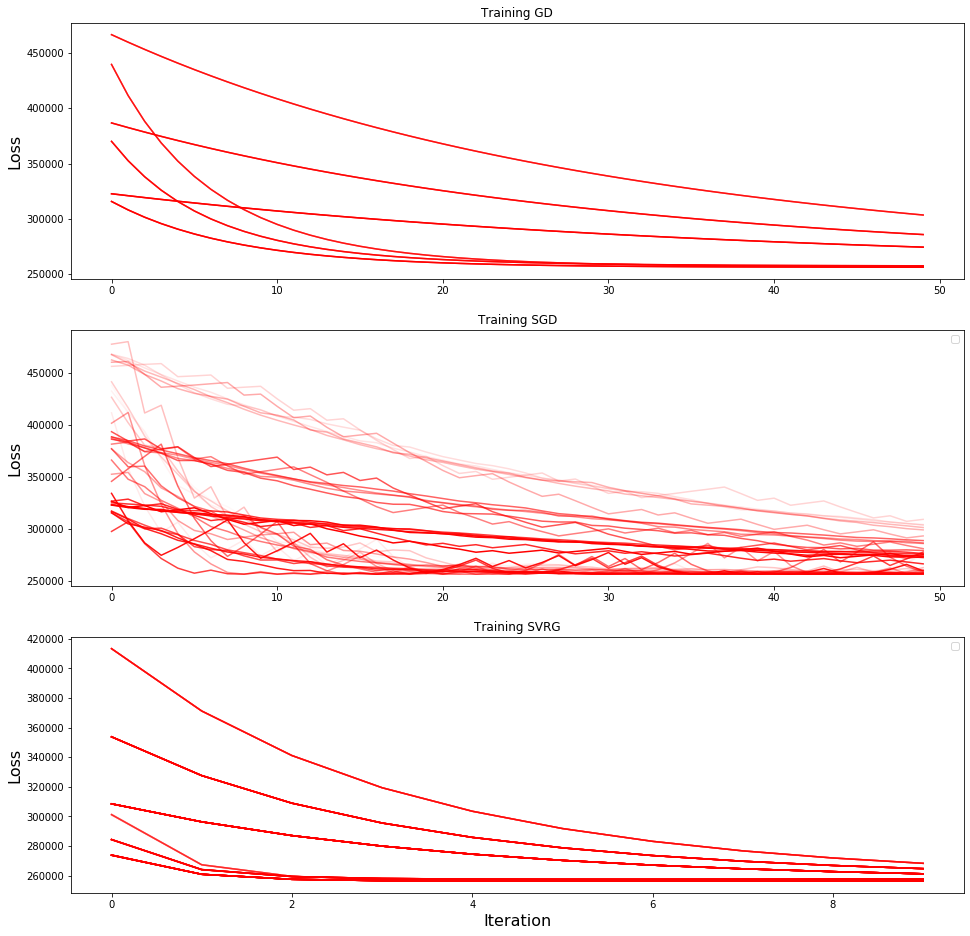

In [16]:

file = open('Hyper', 'rb')
GD_cost,GD_params,GD_ti,SGD_cost,SGD_params,SGD_ti,SVRG_cost,SVRG_params,SVRG_ti=pk.load(file)
file.close()


# Plot results
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
#ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("Training GD")
#ax[0].set_ylim(ymin=0)

ax[1].legend(loc="upper right")
#ax[1].set_xlabel(r"Iteration", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_title("Training SGD")
#ax[0].set_ylim(ymin=0)

ax[2].legend(loc="upper right")
ax[2].set_xlabel(r"Iteration", fontsize=16)
ax[2].set_ylabel("Loss", fontsize=16)
ax[2].set_title("Training SVRG")
#ax[0].set_ylim(ymin=0)


for i in range(len(GD_cost)):
    alpha=(len(SGD_cost)-i)/len(SGD_cost)
        
    ax[0].plot(GD_cost[i],color=(1,0,0,alpha),label='W_d='+str(GD_params[i][0])+', lmba='+str(GD_params[i][1])+', Lr='+str(GD_params[i][2]))
    #ax[0].legend(loc="upper right")

for i in range(len(SGD_cost)):
    alpha=(len(SGD_cost)-i)/len(SGD_cost)
    ax[1].plot(SGD_cost[i],color=(1,0,0,alpha),label='W_d='+str(SGD_params[i][0])+', lmba='+str(SGD_params[i][1])+', Lr='+str(SGD_params[i][2])+', B_size='+str(SGD_params[i][3]))
    #ax[1].legend(loc="upper right")

for i in range(len(SVRG_cost)):
    alpha=(len(SVRG_cost)-i)/len(SVRG_cost)   
    ax[2].plot(SVRG_cost[i],color=(1,0,0,alpha),label='W_d='+str(SVRG_params[i][0])+', lmba='+str(SVRG_params[i][1])+', Lr='+str(SVRG_params[i][2])+', T_loop='+str(SVRG_params[i][3])+', ineer_batch='+str(SVRG_params[i][4]))
    #ax[2].legend(loc="upper right")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


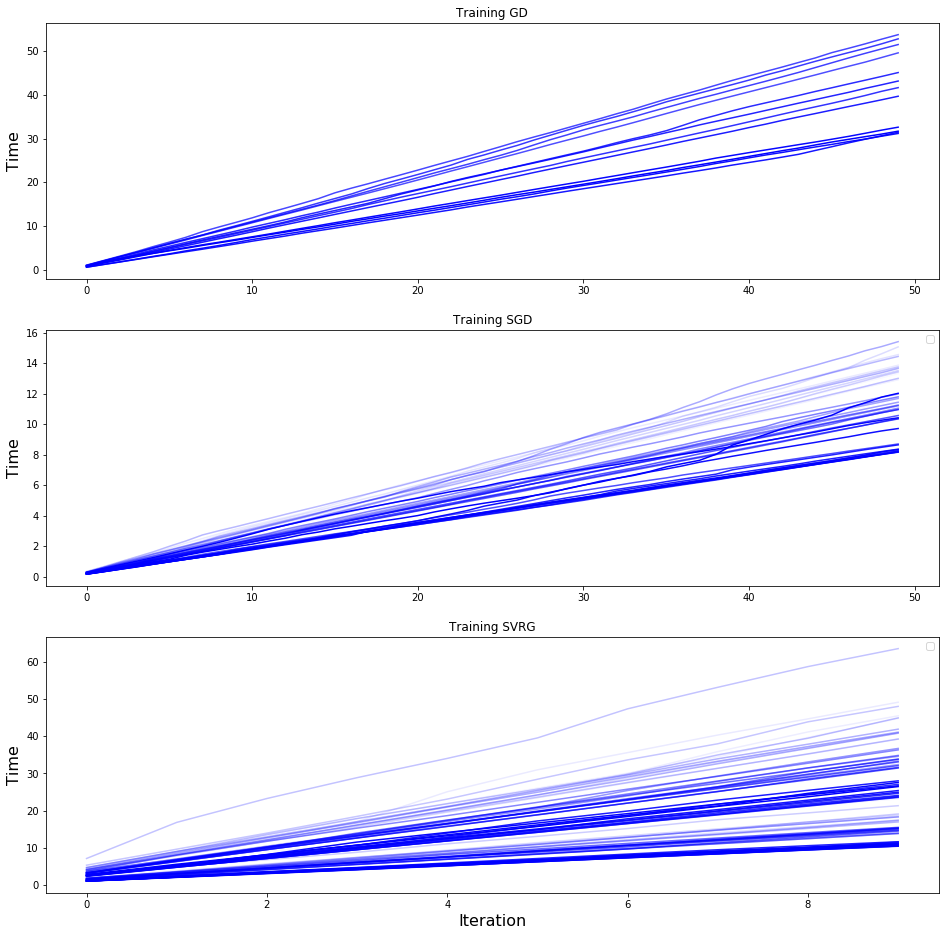

In [18]:
# Plot results
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
#ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Time", fontsize=16)
ax[0].set_title("Training GD")
#ax[0].set_ylim(ymin=0)

ax[1].legend(loc="upper right")
#ax[1].set_xlabel(r"Iteration", fontsize=16)
ax[1].set_ylabel("Time", fontsize=16)
ax[1].set_title("Training SGD")
#ax[0].set_ylim(ymin=0)

ax[2].legend(loc="upper right")
ax[2].set_xlabel(r"Iteration", fontsize=16)
ax[2].set_ylabel("Time", fontsize=16)
ax[2].set_title("Training SVRG")
#ax[0].set_ylim(ymin=0)


for i in range(len(GD_ti)):
    alpha=(len(SGD_ti)-i)/len(SGD_ti)
        
    ax[0].plot(GD_ti[i],color=(0,0,1,alpha),label='W_d='+str(GD_params[i][0])+', lmba='+str(GD_params[i][1])+', Lr='+str(GD_params[i][2]))
    #ax[0].legend(loc="upper right")

for i in range(len(SGD_ti)):
    alpha=(len(SGD_ti)-i)/len(SGD_ti)
    ax[1].plot(SGD_ti[i],color=(0,0,1,alpha),label='W_d='+str(SGD_params[i][0])+', lmba='+str(SGD_params[i][1])+', Lr='+str(SGD_params[i][2])+', B_size='+str(SGD_params[i][3]))
    #ax[1].legend(loc="upper right")

for i in range(len(SVRG_ti)):
    alpha=(len(SVRG_ti)-i)/len(SVRG_ti)   
    ax[2].plot(SVRG_ti[i],color=(0,0,1,alpha),label='W_d='+str(SVRG_params[i][0])+', lmba='+str(SVRG_params[i][1])+', Lr='+str(SVRG_params[i][2])+', T_loop='+str(SVRG_params[i][3])+', ineer_batch='+str(SVRG_params[i][4]))
    #ax[2].legend(loc="upper right")

GD parameters [2, 0.005, 0.05] 256276.1741356935
SGD parameters [2, 0.005, 0.05, 100] 256237.24101751985
SVRG parameters [2, 0.005, 0.05, 5, 1] 256174.4475320275


Text(0.5, 1.0, 'Best trained')

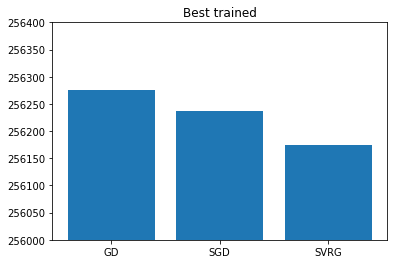

In [19]:
x=np.arange(3)

GD_besti=np.argmin([item[-1] for item in GD_cost])
SGD_besti=np.argmin([item[-1] for item in SGD_cost])
SVRG_besti=np.argmin([item[-1] for item in SVRG_cost])

print("GD parameters",GD_params[GD_besti],GD_cost[GD_besti][-1])
print("SGD parameters",SGD_params[SGD_besti],SGD_cost[SGD_besti][-1])
print("SVRG parameters",SVRG_params[SVRG_besti],SVRG_cost[SVRG_besti][-1])

x=np.arange(3)
plt.bar(x,[GD_cost[GD_besti][-1],SGD_cost[SGD_besti][-1],SVRG_cost[SVRG_besti][-1]])
plt.xticks(x, ('GD', 'SGD', 'SVRG'))
plt.ylim(ymin=256000,ymax=256400)
plt.title('Best trained')

([<matplotlib.axis.XTick at 0x18080950be0>,
 <a list of 3 Text xticklabel objects>)

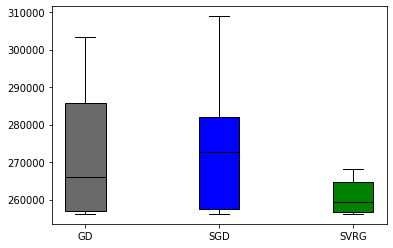

In [20]:
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
def setBoxColors(bp,color,fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=color)        
        
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

labels=['GD','SGD','SVRG']
bp=plt.boxplot([item[-1] for item in GD_cost],positions=[1],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','dimgray')
bp=plt.boxplot([item[-1] for item in SGD_cost],positions=[3],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','blue')
bp=plt.boxplot([item[-1] for item in SVRG_cost],positions=[5],widths=0.6, patch_artist=True)
setBoxColors(bp,'black','green')

plt.xticks([1, 3, 5], labels)